<a href="https://colab.research.google.com/github/HR0262/PCMCI-in-commuter-trian/blob/main/Lyapunov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Station: Arlanda central, Lyapunov Exponent: 0.4780
Station: Barkarby, Lyapunov Exponent: 0.2196
Station: Bro, Lyapunov Exponent: 0.4200
Station: Bålsta, Lyapunov Exponent: 0.3540
Station: Farsta strand, Lyapunov Exponent: 0.1040
Station: Flemingsberg, Lyapunov Exponent: 0.1298
Station: Gnesta, Lyapunov Exponent: 0.3953
Station: Gröndalsviken, Lyapunov Exponent: 0.3063
Station: Handen, Lyapunov Exponent: 0.2845
Station: Helenelund, Lyapunov Exponent: 0.3658
Station: Hemfosa, Lyapunov Exponent: 0.5450
Station: Huddinge, Lyapunov Exponent: 0.2014
Station: Häggvik, Lyapunov Exponent: 0.2504
Station: Jakobsberg, Lyapunov Exponent: 0.3268
Station: Jordbro, Lyapunov Exponent: 0.1839
Station: Järna, Lyapunov Exponent: 0.2305
Station: Kallhäll, Lyapunov Exponent: 0.1111
Station: Knivsta, Lyapunov Exponent: 0.5623
Station: Krigslida, Lyapunov Exponent: 0.4030
Station: Kungsängen, Lyapunov Exponent: 0.1870
Station: Märsta, Lyapunov Exponent: 0.3047
Station: Mölnbo, Lyapunov Exponent: 0.1707
Stat

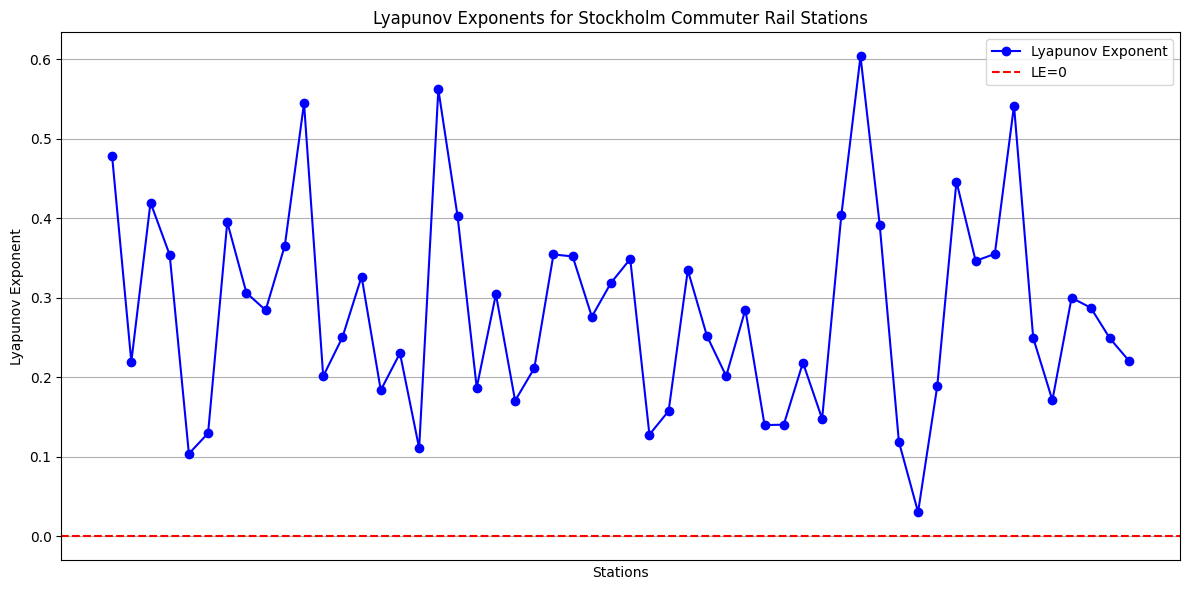

Arlanda central: Positive Lyapunov Exponent (0.4780) -> Likely Nonlinear/Chaotic
Barkarby: Positive Lyapunov Exponent (0.2196) -> Likely Nonlinear/Chaotic
Bro: Positive Lyapunov Exponent (0.4200) -> Likely Nonlinear/Chaotic
Bålsta: Positive Lyapunov Exponent (0.3540) -> Likely Nonlinear/Chaotic
Farsta strand: Positive Lyapunov Exponent (0.1040) -> Likely Nonlinear/Chaotic
Flemingsberg: Positive Lyapunov Exponent (0.1298) -> Likely Nonlinear/Chaotic
Gnesta: Positive Lyapunov Exponent (0.3953) -> Likely Nonlinear/Chaotic
Gröndalsviken: Positive Lyapunov Exponent (0.3063) -> Likely Nonlinear/Chaotic
Handen: Positive Lyapunov Exponent (0.2845) -> Likely Nonlinear/Chaotic
Helenelund: Positive Lyapunov Exponent (0.3658) -> Likely Nonlinear/Chaotic
Hemfosa: Positive Lyapunov Exponent (0.5450) -> Likely Nonlinear/Chaotic
Huddinge: Positive Lyapunov Exponent (0.2014) -> Likely Nonlinear/Chaotic
Häggvik: Positive Lyapunov Exponent (0.2504) -> Likely Nonlinear/Chaotic
Jakobsberg: Positive Lyapuno

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# 1. 读取CSV数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    time_bins = df['time_bin'].values
    stations = df.drop(columns=['time_bin']).columns
    data = df.drop(columns=['time_bin']).values
    return time_bins, stations, data

# 2. 相空间重构
def phase_space_reconstruction(series, m, tau):
    n = len(series)
    M = n - (m - 1) * tau
    if M <= 0:
        return None
    X = np.zeros((M, m))
    for i in range(M):
        for j in range(m):
            X[i, j] = series[i + j * tau]
    return X

# 3. 找到最近邻点
def find_nearest_neighbor(X, idx, min_time_separation):
    min_dist = float('inf')
    nn_idx = -1
    for i in range(len(X)):
        if abs(i - idx) > min_time_separation:
            dist = euclidean(X[idx], X[i])
            if dist < min_dist and dist > 0:
                min_dist = dist
                nn_idx = i
    return nn_idx, min_dist

# 4. 计算Lyapunov指数
def lyapunov_exponent(series, m=3, tau=1, min_time_separation=5, max_iter=10):
    series = series[~np.isnan(series)]
    if len(series) < (m - 1) * tau + max_iter:
        return np.nan
    X = phase_space_reconstruction(series, m, tau)
    if X is None:
        return np.nan
    divergence = []
    for i in range(len(X)):
        nn_idx, initial_dist = find_nearest_neighbor(X, i, min_time_separation)
        if nn_idx == -1:
            continue
        for t in range(1, min(max_iter, len(X) - max(i, nn_idx))):
            dist_t = euclidean(X[i + t], X[nn_idx + t])
            if dist_t > 0:
                divergence.append(np.log(dist_t / initial_dist) / t)
    if not divergence:
        return np.nan
    return np.mean(divergence)

# 5. 主函数：处理所有站点的Lyapunov指数并绘制折线图
def compute_lyapunov_for_stations(file_path):
    # 加载数据
    time_bins, stations, data = load_data(file_path)

    # 存储结果
    results = {}

    # 对每个站点计算Lyapunov指数
    for idx, station in enumerate(stations):
        series = data[:, idx]
        if np.all(series == 0) or np.all(np.isnan(series)):
            results[station] = np.nan
            continue
        lyap_exp = lyapunov_exponent(series, m=3, tau=1, min_time_separation=5, max_iter=10)
        results[station] = lyap_exp
        print(f"Station: {station}, Lyapunov Exponent: {lyap_exp:.4f}")

    # 筛选有效结果
    valid_stations = [k for k, v in results.items() if not np.isnan(v)]
    valid_lyap = [v for v in results.values() if not np.isnan(v)]

    # 绘制折线图
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(valid_stations)), valid_lyap, marker='o', linestyle='-', color='b', label='Lyapunov Exponent')
    plt.axhline(y=0, color='r', linestyle='--', label='LE=0')
    plt.xlabel('Stations')  # x轴名称
    plt.ylabel('Lyapunov Exponent')
    plt.title('Lyapunov Exponents for Stockholm Commuter Rail Stations')
    plt.xticks([])  # 移除x轴的站点名称刻度
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# 6. 运行代码
file_path = '0427_delaymean_None_300600_15.csv'  # 替换为你的文件路径
results = compute_lyapunov_for_stations(file_path)

# 7. 判断非线性
for station, lyap_exp in results.items():
    if np.isnan(lyap_exp):
        continue
    if lyap_exp > 0:
        print(f"{station}: Positive Lyapunov Exponent ({lyap_exp:.4f}) -> Likely Nonlinear/Chaotic")
    elif lyap_exp < 0:
        print(f"{station}: Negative Lyapunov Exponent ({lyap_exp:.4f}) -> Likely Stable")
    else:
        print(f"{station}: Lyapunov Exponent ~0 ({lyap_exp:.4f}) -> Likely Periodic/Quasi-periodic")